# Look at the damn birds 🐦

In [144]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import osmnx as ox
import networkx as nx
import spaghetti
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from collections import Counter

In [2]:
birds = pd.read_csv('../data/birds.csv')
birds = birds.drop(columns='Unnamed: 0')

In [3]:
birds.head()

,Dato,Turtidfra,Turtidtil,Loknr,Loknavn,Artnr,Artnavn,Latin,Sortering,Antal,...,Hemmelig,Kvalitet,Turid,Obsid,DOF_afdeling,lok_laengdegrad,lok_breddegrad,obs_laengdegrad,obs_breddegrad,radius
0,2024-04-17,06:11,NaN,101072,Amager Fælled,110,Nordisk Lappedykker,Podiceps auritus,1410,1,...,0,1,5325297,34145618,DOF København,12.573829,55.649143,12.585059,55.652415,50.0
1,2024-04-17,NaN,NaN,101013,Utterslev Mose Del III (Østmosen),1580,Kortnæbbet Gås,Anser brachyrhynchus,310,1,...,0,1,5325713,34148597,DOF København,12.519717,55.719944,12.515982,55.717640,31.0
2,2024-04-17,08:22,NaN,171142,Porsemosen (Høje Taastrup / Egedal),1580,Kortnæbbet Gås,Anser brachyrhynchus,310,1,...,0,1,5325489,34146804,DOF København,12.299448,55.694660,12.314819,55.694586,50.0
3,2024-04-17,NaN,NaN,205011,Furesøen eksl. Kalvene,2390,Rød Glente,Milvus milvus,4400,1,...,0,1,5325664,34148195,DOF København,12.418628,55.793140,12.407985,55.810542,164.0
4,2024-04-17,NaN,NaN,905378,Vesterled Sø og Tibberup Å (Hareskovby),6700,Ringdue,Columba palumbus,1470,1,...,0,1,5325356,34145928,DOF København,12.403287,55.754642,12.398897,55.751653,18.0


In [4]:
gdf = gpd.GeoDataFrame(
    birds, geometry=gpd.points_from_xy(birds.obs_laengdegrad, birds.obs_breddegrad), crs="EPSG:4326"
)

### Preprocessing

In [9]:
# project to EPSG:25832
gdf = gdf.to_crs('EPSG:25832')

In [12]:
# remove observations outside of Copenhagen

# load shape of Copenhagen
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
cph = ox.geocode_to_gdf(geocodes)
cph = cph.to_crs('EPSG:25832')
cph_poly = cph.dissolve().geometry.iloc[0]

# find intersecting bird observations
gdf['intersection_geometry'] = gdf.geometry.intersection(cph_poly)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [13]:
# remove observations without exact coordinates
gdf = gdf[~gdf.intersection_geometry.is_empty]

## Visualizing bird sightings
For point pattern plots, we create `gdf_exploded` with duplicate entries based on the number of observations on the location. *This is not used*

In [16]:
gdf_exploded = gdf.loc[gdf.index.repeat(gdf.Antal)]

#### Point pattern plot
Plot each individual observation on the map

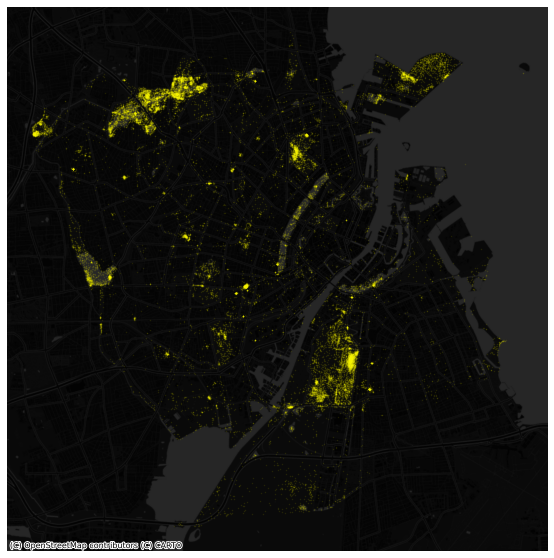

In [208]:
f, ax = plt.subplots(figsize=(10,10))
gdf.plot(
    markersize=0.25,
    c="xkcd:bright yellow",
    alpha=0.1,
    ax=ax)
# cph.plot(ax=ax, column='name', alpha=.2)
cx.add_basemap(source=cx.providers.CartoDB.DarkMatterNoLabels, crs=gdf.crs, ax=ax)
ax.set_axis_off()

#### Point pattern with marginal distribution

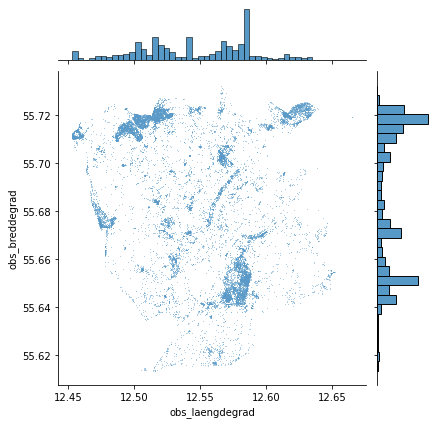

In [209]:
joint_axes = sns.jointplot(
    x='obs_laengdegrad', y='obs_breddegrad', data=gdf, s=0.5
)
# cx.add_basemap(
#     joint_axes.ax_joint,
#     crs="EPSG:4326",
#     source=cx.providers.CartoDB.PositronNoLabels
# );

#### Point pattern of N most common bird types

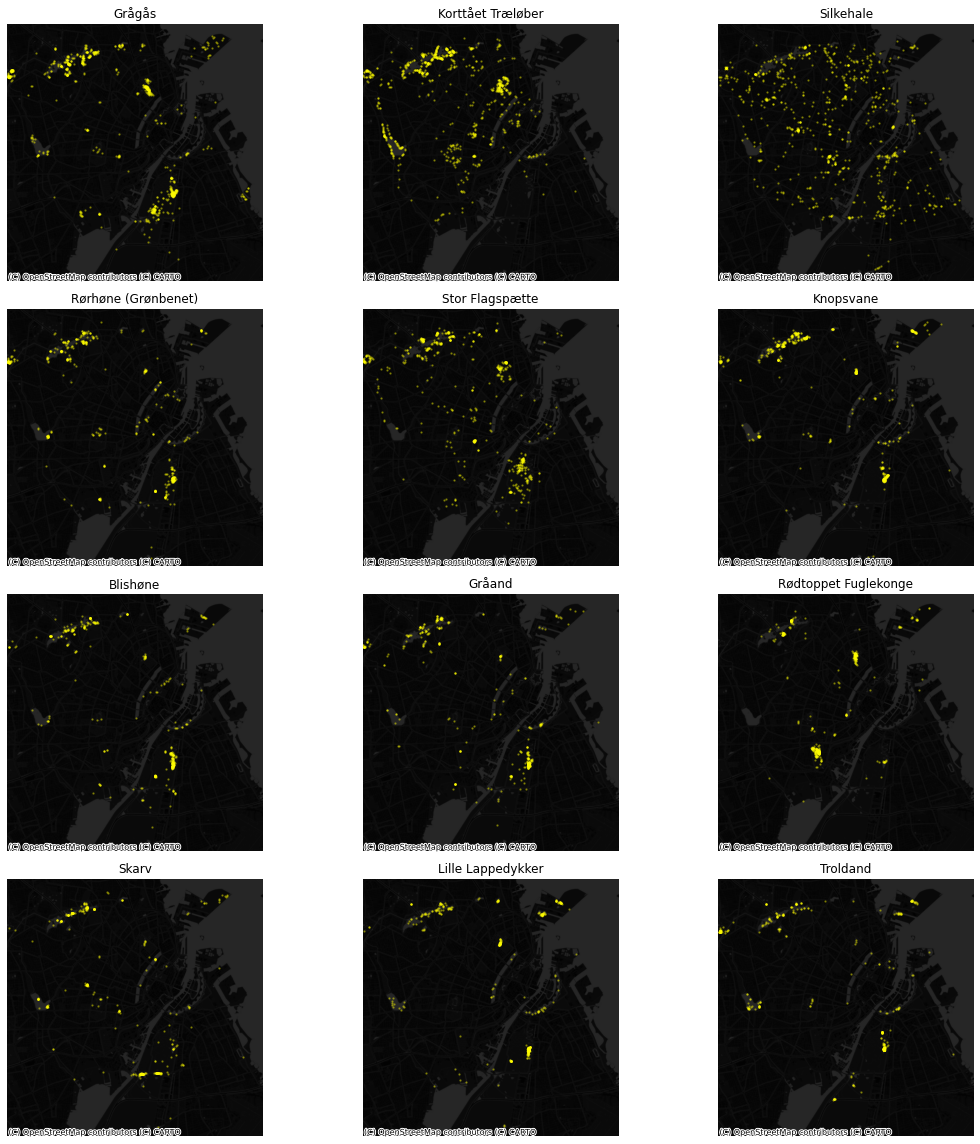

In [211]:
N = 12
bird_types = gdf.Artnavn.value_counts().index.to_list()

f, axes = plt.subplots(int(N/3), 3, figsize=(16,16))
axes = axes.flatten()

minx, miny, maxx, maxy = gdf.geometry.total_bounds

for i in range(N):
    ax = axes[i]
    bird_type = bird_types[i]
    
    type_df = gdf[gdf.Artnavn == bird_type]
    ax.scatter(type_df.geometry.x, type_df.geometry.y, s=2, c="xkcd:bright yellow", alpha=0.3)
    
    ax.set_title(bird_type)
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_axis_off()
    
    cx.add_basemap(ax=ax, crs=type_df.crs, source=cx.providers.CartoDB.DarkMatterNoLabels)
    
plt.tight_layout()

#### Hexbin

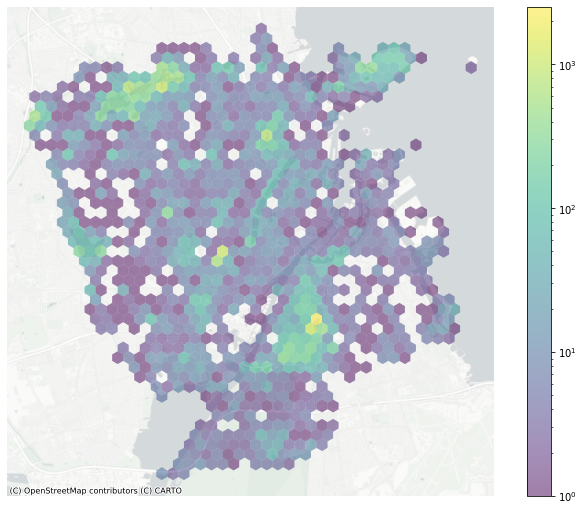

In [212]:
f, ax = plt.subplots(1, figsize=(12, 9))
hb = ax.hexbin(
    gdf.geometry.x, 
    gdf.geometry.y, 
    gridsize=40, 
    alpha=0.5,
    edgecolor="none",
    bins='log',
    mincnt=1
)

plt.colorbar(hb)

cx.add_basemap(source=cx.providers.CartoDB.PositronNoLabels, crs=gdf.crs, ax=ax)
ax.set_axis_off()

#### KDE plot

Text(0.5, 1.0, 'KDE of photos in Tokyo')

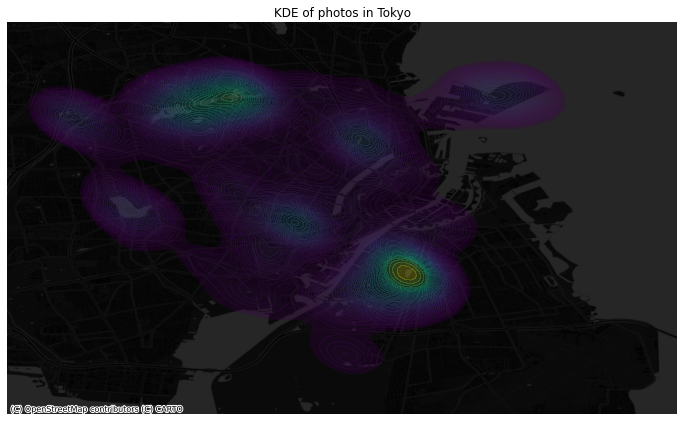

In [213]:
f, ax = plt.subplots(1, figsize=(12, 12))

sns.kdeplot(
    data=gdf,
    x='obs_laengdegrad', 
    y='obs_breddegrad', 
    n_levels=50, 
    shade=True,
    alpha=0.25,
    cmap="viridis"
)

ax.set_axis_off()
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
ax.set_title("KDE of photos in Tokyo")

## Birds in relation to bike paths
We want to use bird observations as an edge feature on the bicycle street network.
### Load data

In [48]:
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


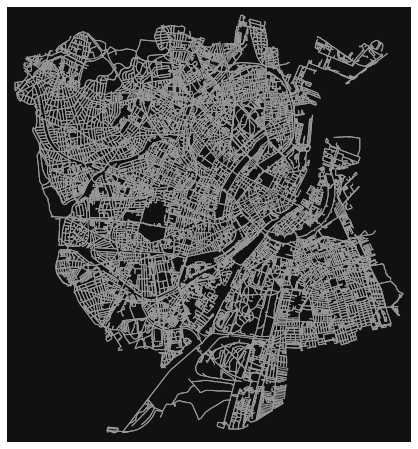

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [15]:
ox.plot_graph(G, node_size=0)

In [82]:
# ox.io.save_graph_shapefile(G, "copenhagen")

/opt/conda/lib/python3.9/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [85]:
# be careful, this takes forever
# ntw = spaghetti.Network(in_data="copenhagen/edges.shp")

In [87]:
# ntw.savenetwork('copenhagen_ntw')

In [69]:
ntw = spaghetti.Network.loadnetwork('copenhagen_ntw')

In [70]:
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)

### Pointwise snap each observation to nearest point on road
With this approach, we project each observation to its nearest point on its nearest street

In [75]:
sample = gdf#.sample(1000)

In [76]:
ntw.snapobservations(sample, 'birds', attribute=True)
ntw.pointpatterns

{'birds': <spaghetti.network.PointPattern at 0x754ea8b42820>}

In [77]:
sample_snapped = spaghetti.element_as_gdf(ntw, pp_name='birds', snapped=True)

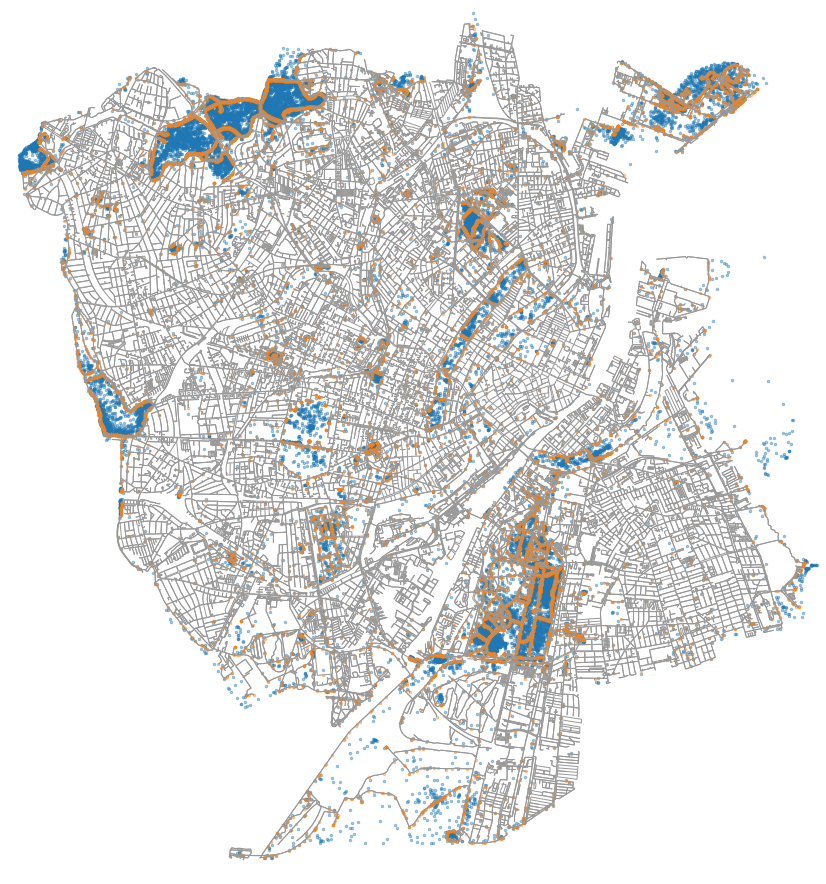

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

In [83]:
f, ax = plt.subplots(figsize=(16,16))

sample.plot(ax=ax, alpha=.4, markersize=6)
sample_snapped.plot(ax=ax, alpha=.4, markersize=6)

ox.plot_graph(G, node_size=0, bgcolor="w", ax=ax)

### Pointwise snap each observation to nearest road
Here, we attribute each observation to a street edge, treating it as an edge attribute

In [60]:
# map each observation to nearest street and count observations per street
x = gdf.geometry.x.to_list()
y = gdf.geometry.y.to_list()
ne = ox.nearest_edges(G, x, y)

cnt = Counter()
for edge in ne:
    cnt[edge] += 1

In [141]:
# use observation count as edge attribute
nx.set_edge_attributes(G, cnt, 'birds')

In [167]:
# convert graph to geodataframe
nodes, edges = ox.graph_to_gdfs(G)

In [170]:
# impute 0 on streets with no observations
edges['birds'] = edges['birds'].fillna(0)

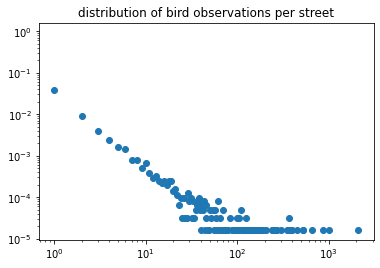

In [207]:
# plot distribution of bird observations - power law?
x = edges.birds.to_list()
x, y = np.unique(x, return_counts=True)
y = y / np.sum(y)

f, ax = plt.subplots()
ax.scatter(x, y)

ax.set_title('distribution of bird observations per street')

ax.set_xscale('log')
ax.set_yscale('log')

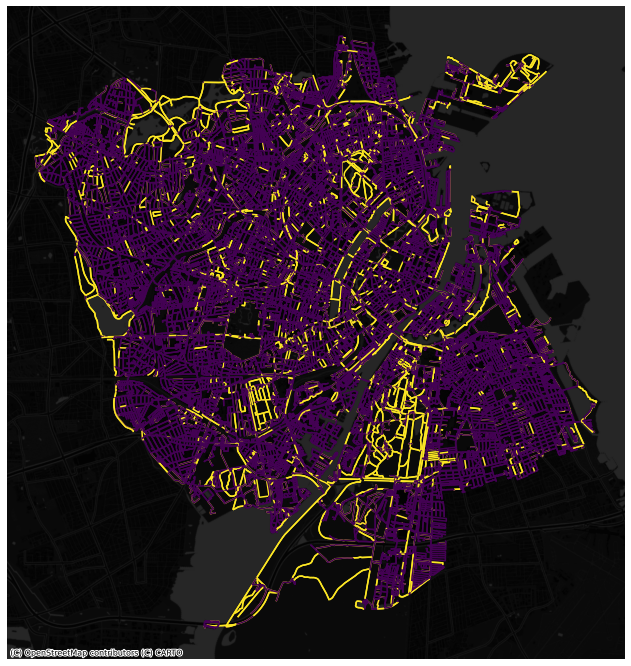

In [194]:
# plot streets with bird activity
f, ax = plt.subplots(figsize=(12,12))
edges.plot(
    column='birds',
    scheme='quantiles',
    k=2,
    ax=ax)
ax.set_axis_off()
cx.add_basemap(
    ax, 
    crs=edges.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

### Buffer snapping
Instead of strictly snapping to nearest street, we create a buffer around each observation, and any street intersecting with said buffer will be attributed the bird observation. This approach is more lenient to small measurement errors.